In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import logging
import yaml

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import functions as sf
from pyspark.sql.types import IntegerType

from replay.data_preparator import DataPreparator, CatFeaturesTransformer, Indexer
from replay.session_handler import get_spark_session
from replay.splitters import UserSplitter
from replay.filters import filter_by_min_count


In [2]:
spark = get_spark_session(20)


22/07/20 15:43:18 WARN Utils: Your hostname, recsys-automl resolves to a loopback address: 127.0.1.1; using 192.168.0.5 instead (on interface ens160)
22/07/20 15:43:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/07/20 15:43:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/20 15:43:19 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
seed = 1909


In [4]:
logger_config = """
version: 1
formatters:
    simple:
        class: logging.Formatter
        format: "%(asctime)s, %(name)s, %(levelname)s: %(message)s"
        datefmt: "%d-%b-%y %H:%M:%S"
handlers:
    file_handler:
        class: logging.FileHandler
        filename: logs/data_preparation.log
        level: DEBUG
        formatter: simple
    stream_handler:
        class: logging.StreamHandler
        stream: ext://sys.stdout
        level: DEBUG
        formatter: simple
loggers:
    data_preparation_logger:
        level: DEBUG
        handlers: [file_handler, stream_handler]
        propagate: no
"""
logger = logging.getLogger(name="data_preparation_logger")

config = yaml.load(logger_config, Loader=yaml.FullLoader)
logging.config.dictConfig(config)


# Anime data

In [5]:
data_path = "data/anime/"
ratings_file_name = "ratings.csv"
items_file_name = "items.csv"

ratings = pd.read_csv(f"{data_path}{ratings_file_name}")
items = pd.read_csv(f"{data_path}{items_file_name}")


In [6]:
print(ratings.shape)
display(ratings.head(10))


(7813737, 3)


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


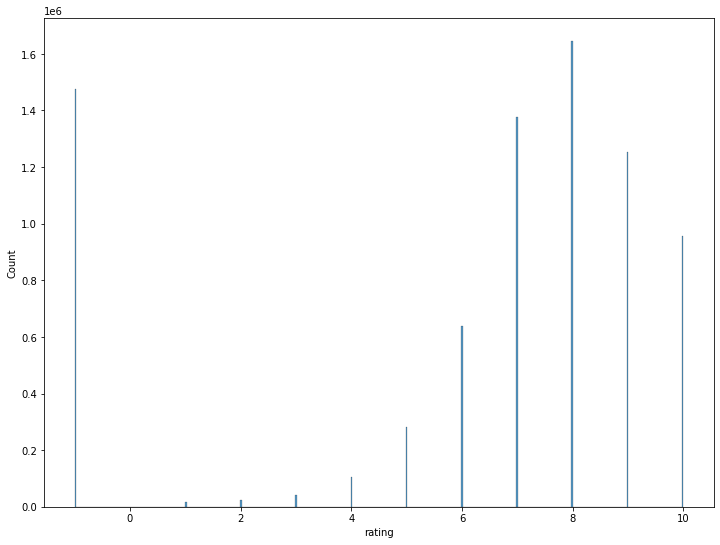

In [7]:
plt.figure(figsize=(12, 9))
sns.histplot(ratings["rating"])
plt.show()


In [8]:
print(items.shape)
items.head(10)


(12294, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


In [9]:
user_count = ratings.user_id.nunique()
item_count = ratings.anime_id.nunique()
rating_count = ratings.shape[0]
print(
    f"User count: {user_count}",
    f"Item count: {item_count}",
    f"Ratings count: {rating_count}",
    f"interactions / (users * items) : {rating_count / (user_count * item_count)}",
    sep="\n",
)


User count: 73515
Item count: 11200
Ratings count: 7813737
interactions / (users * items) : 0.009489969248258373


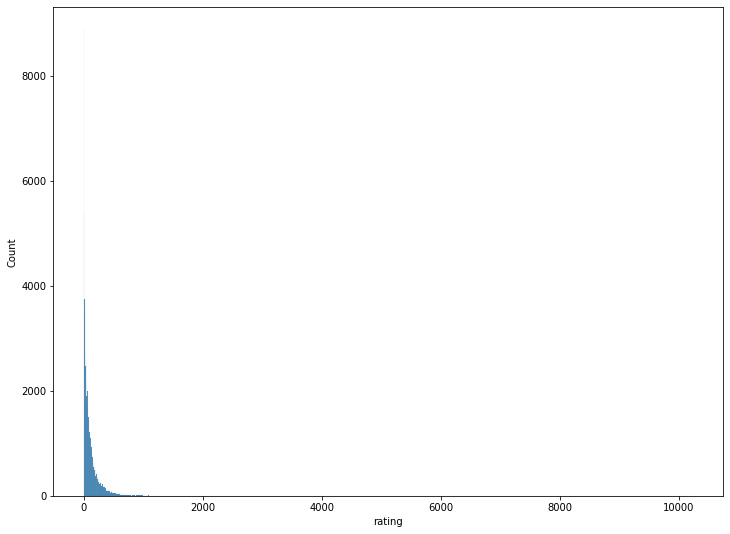

In [10]:
ratings_group = ratings.groupby("user_id")
ratings_group_count = ratings_group.count()

plt.figure(figsize=(12, 9))
sns.histplot(ratings_group_count.rating)
plt.show()


In [11]:
ratings["timestamp"] = np.arange(ratings.shape[0])

ratings.drop(ratings[ratings["rating"] < 7].index, axis=0, inplace=True)
ratings["rating"] = np.ones(ratings.shape[0])


In [12]:
items.drop("name", axis=1, inplace=True)
items.drop(items[items["episodes"] == "Unknown"].index, axis=0, inplace=True)
items["episodes"] = items["episodes"].astype(int)
items.dropna(inplace=True)

items["members"], lambda_for_members = ss.boxcox(items.members)

items["is_film"] = items["episodes"].apply(lambda x: 1 if x == 1 else 0)


In [13]:
data_prep = DataPreparator()
log = data_prep.transform(
    data=ratings,
    columns_mapping={"relevance": "rating", "item_id": "anime_id"},
)
item_features = data_prep.transform(
    data=items,
    columns_mapping={"item_id": "anime_id"},
)


22/07/20 15:43:34 WARN TaskSetManager: Stage 0 contains a task of very large size (13627 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:43:35 WARN TaskSetManager: Stage 1 contains a task of very large size (13627 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:43:35 WARN TaskSetManager: Stage 3 contains a task of very large size (13627 KiB). The maximum recommended task size is 1000 KiB.
20-Jul-22 15:43:36, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


In [14]:
item_id = item_features.select(sf.col("item_id").alias("item_id_"))
log = log.join(
    item_id,
    log.item_id == item_id.item_id_,
    "inner",
).drop(sf.col("item_id_"))


In [15]:
log = filter_by_min_count(
    log,
    num_entries=15,  # 10 test/val, 5 train
    group_by="user_id",
)


22/07/20 15:43:37 WARN TaskSetManager: Stage 8 contains a task of very large size (13627 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:43:39 WARN TaskSetManager: Stage 12 contains a task of very large size (13627 KiB). The maximum recommended task size is 1000 KiB.
20-Jul-22 15:43:41, replay, INFO: current threshold removes 0.022639610773801364% of data


In [16]:
indexer = Indexer(user_col="user_id", item_col="item_id")
indexer.fit(users=log.select("user_id").distinct(), items=item_features.select("item_id"))
log = indexer.transform(log)
item_features = indexer.transform(item_features)


22/07/20 15:43:43 WARN TaskSetManager: Stage 19 contains a task of very large size (13627 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:43:45 WARN TaskSetManager: Stage 26 contains a task of very large size (13627 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:43:47 WARN TaskSetManager: Stage 32 contains a task of very large size (13627 KiB). The maximum recommended task size is 1000 KiB.


In [17]:
train, test = UserSplitter(
    item_test_size=10,
    shuffle=False,
    seed=seed,
    drop_cold_items=True,
    drop_cold_users=True,
).split(log)


22/07/20 15:43:49 WARN TaskSetManager: Stage 39 contains a task of very large size (13627 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:43:49 WARN DAGScheduler: Broadcasting large task binary with size 1800.1 KiB
22/07/20 15:43:50 WARN DAGScheduler: Broadcasting large task binary with size 1790.2 KiB
22/07/20 15:43:51 WARN TaskSetManager: Stage 48 contains a task of very large size (13627 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:43:51 WARN TaskSetManager: Stage 47 contains a task of very large size (13627 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:43:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/07/20 15:43:52 WARN DAGScheduler: Broadcasting large task binary with size 1801.3 KiB
22/07/20 15:43:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/07/20 15:43:57 WARN TaskSetManager: Stage 66 contains a task of very large size (13627 KiB). The maximum recommended task size is

In [18]:
cat_feat_prep = CatFeaturesTransformer(cat_cols_list=["type"])
cat_feat_prep.fit(item_features)
item_features = cat_feat_prep.transform(item_features)


In [19]:
item_features = (
    item_features.withColumn("genre_collection", sf.split("genre", ", "))
    .drop("genre")
    .withColumnRenamed("genre_collection", "genre")
)
genres_list = (
    item_features.select(sf.explode("genre").alias("genre"))
    .distinct()
    .toPandas()
    .genre.tolist()
)


In [20]:
for genre in genres_list:
    item_features = item_features.withColumn(
        f"genre_{genre}",
        sf.array_contains(sf.col("genre"), genre).astype(IntegerType()),
    )
item_features = item_features.drop("genre")


In [21]:
train.toPandas().to_csv(
    f"{data_path}train.csv",
    index=False,
)
test.toPandas().to_csv(
    f"{data_path}test.csv",
    index=False,
)
item_features.toPandas().to_csv(
    f"{data_path}item_features.csv",
    index=False,
)


22/07/20 15:44:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/07/20 15:44:11 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/07/20 15:44:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# BookCrossing data

In [58]:
data_path = "data/bookcrossing/"
ratings_file_name = "ratings.csv"
items_file_name = "items.csv"
users_file_name = "users.csv"

ratings = pd.read_csv(f"{data_path}{ratings_file_name}")
items = pd.read_csv(f"{data_path}{items_file_name}")
users = pd.read_csv(f"{data_path}{users_file_name}")


In [59]:
print(ratings.shape)
print("interactions")
ratings.head()


(1149780, 3)
interactions


,user_id,item_id,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


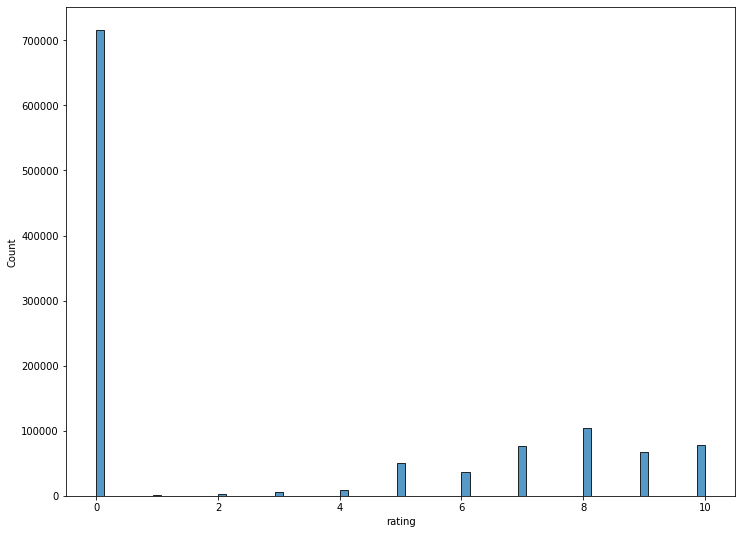

In [60]:
plt.figure(figsize=(12, 9))
sns.histplot(ratings["rating"])
plt.show()


In [61]:
ratings[ratings["rating"] > 6].shape


(326344, 3)

In [62]:
print(items.shape)
print("items")
items.head()


(271379, 8)
items


,item_id,title,author,year,publisher,img_s,img_m,img_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [63]:
print(users.shape)
print("users")
users.head()


(278858, 3)
users


,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [65]:
user_count = ratings.user_id.nunique()
item_count = ratings.item_id.nunique()
rating_count = ratings.shape[0]
print(
    f"User count: {user_count}",
    f"Item count: {item_count}",
    f"Ratings count: {rating_count}",
    f"interactions / (users * items) : {rating_count / (user_count * item_count)}",
    sep="\n",
)


User count: 105283
Item count: 340556
Ratings count: 1149780
interactions / (users * items) : 3.206771109452608e-05


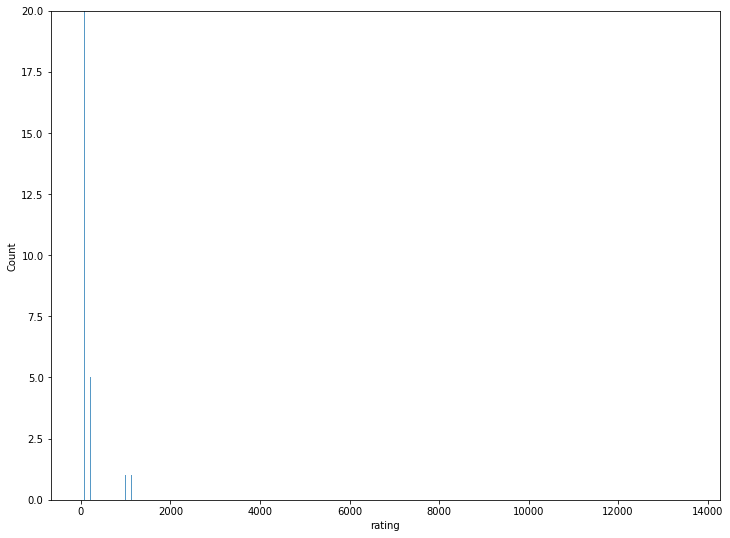

1     59166
2     12502
3      6534
4      4265
5      3099
6      2334
7      1725
8      1388
9      1173
10     1044
11      856
12      729
13      612
14      514
15      489
16      457
17      380
18      327
19      320
20      291
Name: item_id, dtype: int64

In [67]:
ratings_group = ratings.groupby("user_id")
ratings_group_count = ratings_group.count()

plt.figure(figsize=(12, 9))
sns.histplot(ratings_group_count.rating)
plt.ylim((0, 20))
plt.show()

ratings_group_count["item_id"].value_counts().head(20)


In [68]:
ratings["timestamp"] = np.arange(ratings.shape[0])
ratings = ratings[(ratings["rating"] < 7) | (ratings["rating"] == 0)]
ratings["rating"] = np.ones(ratings.shape[0])

item_features_to_drop = ["title", "img_s", "img_m", "img_l", "author"]
items.drop(item_features_to_drop, axis=1, inplace=True)

user_features_to_drop = ["age"]
users.drop(user_features_to_drop, axis=1, inplace=True)
items.dropna(inplace=True)


/tmp/ipykernel_1433046/2665446480.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings["rating"] = np.ones(ratings.shape[0])


In [69]:
users["country"] = users.location.apply(lambda x: x.split(", ")[-1])
users.drop("location", axis=1, inplace=True)
country_categories = set(users.country.value_counts()[:7].index.tolist())
users["country"] = users["country"].apply(
    lambda x: x if x in country_categories else "other"
)


In [70]:
item_publisher_to_other = set(
    items.publisher.value_counts()[items.publisher.value_counts() < 2].index
)
items["publisher"] = items["publisher"].apply(
    lambda x: "other" if x in item_publisher_to_other else x
)


In [71]:
data_prep = DataPreparator()
log = data_prep.transform(
    data=ratings, columns_mapping={"relevance": "rating", "item_id": "item_id"}
)
user_features = data_prep.transform(data=users, columns_mapping={"user_id": "user_id"})
item_features = data_prep.transform(data=items, columns_mapping={"item_id": "item_id"})


20-Jul-22 15:06:55, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
22/07/20 15:06:55 WARN TaskSetManager: Stage 352 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:06:55 WARN TaskSetManager: Stage 353 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:06:55 WARN TaskSetManager: Stage 355 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
20-Jul-22 15:06:55, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
20-Jul-22 15:06:56, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


In [72]:
log = filter_by_min_count(
    log,
    num_entries=15,  # 10 test, 5 train
    group_by="user_id",
)


22/07/20 15:06:59 WARN TaskSetManager: Stage 363 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:06:59 WARN TaskSetManager: Stage 365 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:06:59 WARN TaskSetManager: Stage 366 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
20-Jul-22 15:06:59, replay, INFO: current threshold removes 0.1931030462598186% of data


In [73]:
indexer = Indexer(user_col="user_id", item_col="item_id")
indexer.fit(users=user_features.select("user_id").distinct(), items=item_features.select("item_id"))
log = indexer.transform(log)
item_features = indexer.transform(item_features)
user_features = indexer.transform(user_features)



22/07/20 15:07:49 WARN TaskSetManager: Stage 374 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:07:49 WARN TaskSetManager: Stage 375 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:08:13 WARN TaskSetManager: Stage 378 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:08:13 WARN TaskSetManager: Stage 379 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.


In [74]:
train, test = UserSplitter(
    item_test_size=10,
    shuffle=False,
    drop_cold_items=True,
    drop_cold_users=True,
).split(
    log.withColumnRenamed("user_id", "user_idx").withColumnRenamed(
        "item_id", "item_idx"
    )
)


22/07/20 15:09:11 WARN TaskSetManager: Stage 385 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:09:11 WARN TaskSetManager: Stage 386 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:09:12 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/07/20 15:09:12 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/07/20 15:09:15 WARN TaskSetManager: Stage 391 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:09:15 WARN TaskSetManager: Stage 390 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:09:15 WARN TaskSetManager: Stage 392 contains a task of very large size (2551 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:09:15 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
22/07/20 15:09:15 WARN DAG

In [75]:
user_features_ohe_encoder = CatFeaturesTransformer(cat_cols_list=["country"])
user_features_ohe_encoder.fit(user_features)
user_features = user_features_ohe_encoder.transform(user_features)


In [76]:
train.toPandas().to_csv(
    f"{data_path}train.csv",
    index=False,
)
test.toPandas().to_csv(
    f"{data_path}test.csv",
    index=False,
)
item_features.toPandas().to_csv(
    f"{data_path}item_features.csv",
    index=False,
)
user_features.toPandas().to_csv(
    f"{data_path}user_features.csv",
    index=False,
)


22/07/20 15:09:29 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
22/07/20 15:09:34 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
22/07/20 15:09:35 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/07/20 15:09:37 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


# Last fm

In [5]:
data_path = "data/lastfm/"
ratings_file_name = "ratings.csv"
users_file_name = "users.csv"

ratings = pd.read_csv(f"{data_path}{ratings_file_name}")
users = pd.read_csv(f"{data_path}{users_file_name}")


In [6]:
print(ratings.shape)
print("interactions")
ratings.head(5)


(17535654, 4)
interactions


,user_id,artist_id,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
1,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
2,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
3,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
4,00000c289a1829a808ac09c00daf10bc3c4e223b,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,691


In [7]:
print(users.shape)
print("users")
users.head(5)


(359346, 5)
users


,user_id,gender,age,country,signup_date
0,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
1,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
2,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
3,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"
4,0000c176103e538d5c9828e695fed4f7ae42dd01,m,20.0,United Kingdom,"Jan 14, 2006"


In [8]:
users.isna().sum()


user_id            0
gender         32775
age            74900
country            0
signup_date        0
dtype: int64

In [9]:
user_count = ratings.user_id.nunique()
item_count = ratings.artist.nunique()
rating_count = ratings.shape[0]
print(
    f"User count: {user_count}",
    f"Item count: {item_count}",
    f"Ratings count: {rating_count}",
    f"interactions / (users * items) : {rating_count / (user_count * item_count)}",
    sep="\n",
)


User count: 358868
Item count: 292363
Ratings count: 17535654
interactions / (users * items) : 0.0001671340063649685


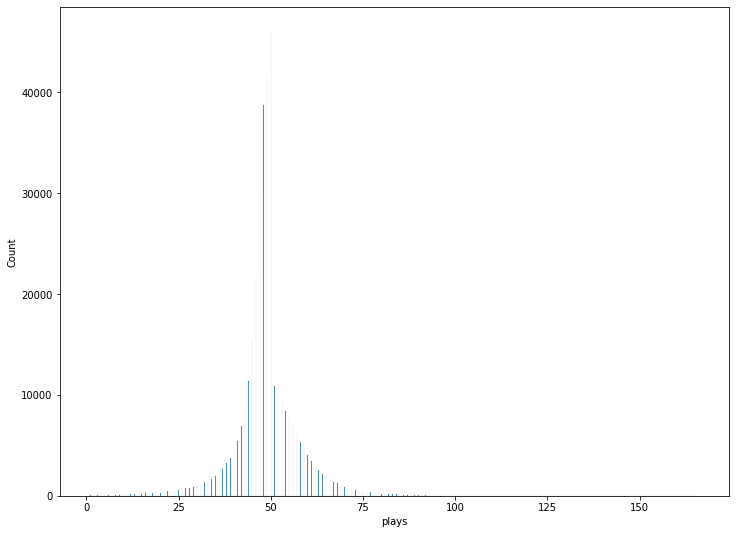

In [10]:
ratings_group = ratings.groupby("user_id")
ratings_group_count = ratings_group.count()

plt.figure(figsize=(12, 9))
sns.histplot(ratings_group_count.plays)
plt.show()


In [11]:
ratings.drop("artist_id", axis=1, inplace=True)
ratings.dropna(axis=0, inplace=True)
ratings["plays"], lambda__ = ss.boxcox(ratings["plays"].values + 1)
print(lambda__)


0.05443730538939532


In [12]:
users["age"].fillna(119, inplace=True)
users = users[(users["age"] > 3) & (users["age"] < 120)]
users.age[users.age == 119] = np.nan


In [13]:
ratings = ratings.merge(users[["user_id"]], how="inner", on="user_id")
users.gender.fillna("nan_value", inplace=True)


In [14]:
countries = set(
    users.groupby("country")
    .count()
    .sort_values("user_id", ascending=False)
    .head(25)
    .index.tolist()
)
users["country"] = users["country"].apply(lambda x: x if x in countries else "other")


In [15]:
target = users.dropna().age.copy()
X = users.dropna()[["country"]]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    target,
    test_size=0.1,
    random_state=20,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.17,
    random_state=20,
)

train_pool = Pool(X_train, y_train, cat_features=["country"])
val_pool = Pool(X_val, y_val, cat_features=["country"])
test_pool = Pool(X_test, y_test, cat_features=["country"])

model = CatBoostRegressor(verbose=False, random_state=20)
model.fit(train_pool, eval_set=val_pool)
pred = model.predict(test_pool)


In [16]:
mean_absolute_error(y_test, pred), mean_squared_error(y_test, pred)


(5.9097751739850235, 90.97169875529791)

In [17]:
nans_pool = Pool(users[users.age.isna()][["country"]], cat_features=["country"])
pred_nans = model.predict(nans_pool)
users.age.fillna(
    pd.Series(pred_nans, index=users[users.age.isna()][["country"]].index), inplace=True
)


In [18]:
ratings["timestamp"] = np.arange(ratings.shape[0])


In [19]:
data_prep = DataPreparator()
log = data_prep.transform(
    columns_mapping={
        "item_id": "artist",
        "relevance": "plays",
    },
    data=ratings,
)
user_features = data_prep.transform(data=users, columns_mapping={"user_id": "user_id"})


22/07/20 15:21:04 WARN TaskSetManager: Stage 0 contains a task of very large size (107888 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:21:05 WARN TaskSetManager: Stage 1 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:21:07 WARN TaskSetManager: Stage 3 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
20-Jul-22 15:21:09, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
22/07/20 15:21:09 WARN TaskSetManager: Stage 5 contains a task of very large size (2524 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:21:09 WARN TaskSetManager: Stage 6 contains a task of very large size (2524 KiB). The maximum recommended task size is 1000 KiB.


In [21]:
log = filter_by_min_count(
    log,
    num_entries=15,  # 10 test, 5 train
    group_by="user_id",
)


22/07/20 15:24:35 WARN TaskSetManager: Stage 8 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:24:37 WARN TaskSetManager: Stage 10 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:24:39 WARN TaskSetManager: Stage 11 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
20-Jul-22 15:24:41, replay, INFO: current threshold removes 0.0007609151538159315% of data


In [23]:
indexer = Indexer(user_col="user_id", item_col="item_id")
indexer.fit(users=user_features.select("user_id").distinct(), items=log.select("item_id"))
log = indexer.transform(log)
user_features = indexer.transform(user_features)


22/07/20 15:35:32 WARN TaskSetManager: Stage 14 contains a task of very large size (2524 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:35:35 WARN TaskSetManager: Stage 17 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:35:36 WARN TaskSetManager: Stage 18 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:35:45 WARN TaskSetManager: Stage 21 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:35:46 WARN TaskSetManager: Stage 22 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:35:51 WARN TaskSetManager: Stage 25 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:35:52 WARN TaskSetManager: Stage 26 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000

In [28]:
train, test = UserSplitter(
    item_test_size=10,
    shuffle=False,
    drop_cold_items=True,
    drop_cold_users=True,
).split(log)


22/07/20 15:38:53 WARN TaskSetManager: Stage 30 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:38:54 WARN TaskSetManager: Stage 31 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:38:55 WARN DAGScheduler: Broadcasting large task binary with size 20.7 MiB
22/07/20 15:39:00 WARN DAGScheduler: Broadcasting large task binary with size 20.7 MiB
22/07/20 15:39:04 WARN TaskSetManager: Stage 36 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:39:05 WARN TaskSetManager: Stage 35 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:39:07 WARN TaskSetManager: Stage 37 contains a task of very large size (107887 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 15:39:08 WARN DAGScheduler: Broadcasting large task binary with size 32.7 MiB
22/07/20 15:39:09 W

In [31]:
train.count(), test.count(), user_features.count()

22/07/20 15:42:00 WARN DAGScheduler: Broadcasting large task binary with size 32.7 MiB
22/07/20 15:42:02 WARN DAGScheduler: Broadcasting large task binary with size 32.8 MiB
22/07/20 15:42:03 WARN TaskSetManager: Stage 106 contains a task of very large size (2524 KiB). The maximum recommended task size is 1000 KiB.


(13914378, 3522481, 358493)

In [30]:
train.toPandas().to_csv(
    f"{data_path}train.csv",
    index=False,
)
test.toPandas().to_csv(
    f"{data_path}test.csv",
    index=False,
)
user_features.toPandas().to_csv(
    f"{data_path}user_features.csv",
    index=False,
)


22/07/20 15:41:13 WARN DAGScheduler: Broadcasting large task binary with size 32.7 MiB
22/07/20 15:41:47 WARN DAGScheduler: Broadcasting large task binary with size 32.8 MiB
22/07/20 15:41:57 WARN DAGScheduler: Broadcasting large task binary with size 20.7 MiB
22/07/20 15:41:57 WARN TaskSetManager: Stage 83 contains a task of very large size (2524 KiB). The maximum recommended task size is 1000 KiB.
